# Pre-Processing Forecasting

## Agregat Data $NO_2$ Harian

In [10]:
import pandas as pd

# ====== Konfigurasi file ======
input_path = "dataset/no2_gresik_day.csv"       # ganti dengan path CSV Anda
output_path = "dataset/data.csv"    # file keluaran

# ====== Baca data ======
# parse kolom t sebagai tanggal (YYYY-MM-DD)
df = pd.read_csv(input_path, parse_dates=['t'])

# ====== Hapus kolom yang tidak diperlukan ======
cols_drop = [c for c in ['x', 'y', 'crs'] if c in df.columns]
df = df.drop(columns=cols_drop)

# (opsional) pastikan hanya baris dengan nilai NO2 valid yang dipakai
# df = df.dropna(subset=['NO2'])

# ====== Hitung rata-rata NO2 per hari ======
# Jika 't' berformat tanggal penuh dan Anda HANYA ingin bagian harinya:
df['t'] = df['t'].dt.date  # ubah ke tipe date (tanpa jam)

no2_harian = (
    df.groupby('t', as_index=False)['NO2']
      .mean()
      .rename(columns={'NO2': 'NO2_mean'})
)

# ====== Simpan hasil ======
no2_harian.to_csv(output_path, index=False)

print("Contoh 5 baris teratas:")
print(no2_harian.head())
print(f"\nDisimpan ke: {output_path}")


Contoh 5 baris teratas:
            t  NO2_mean
0  2021-09-20  0.000055
1  2021-09-21       NaN
2  2021-09-22  0.000021
3  2021-09-23  0.000032
4  2021-09-24  0.000033

Disimpan ke: dataset/data.csv


### Grafik Data Time Series Harian (Sebelum Interpolasi Linear)

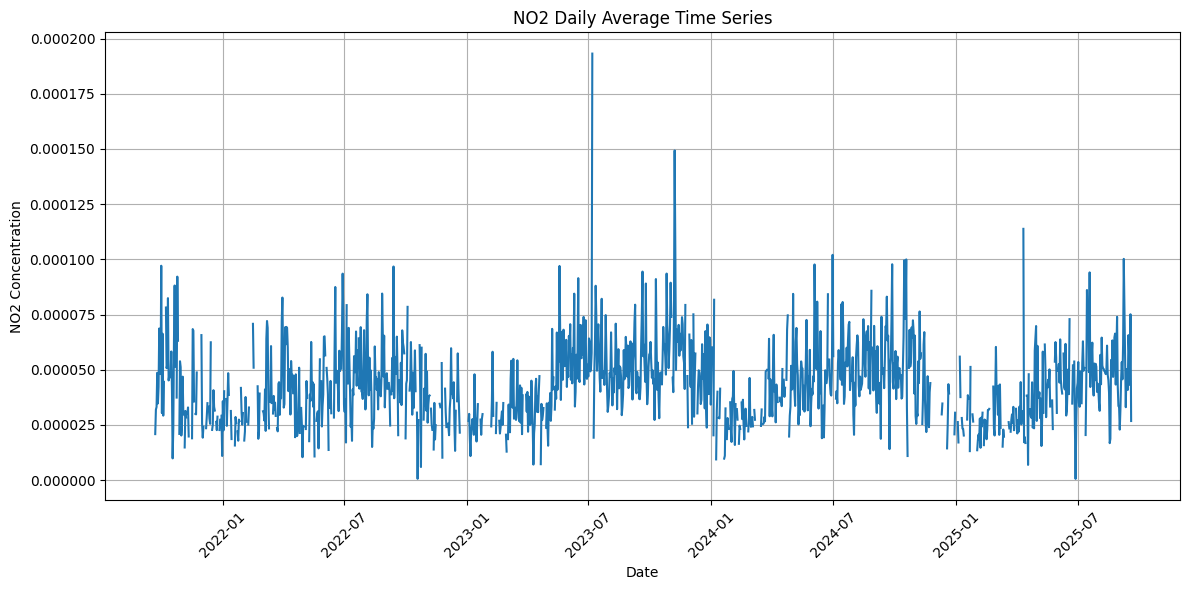

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(no2_harian['t'], no2_harian['NO2_mean'])
plt.title('NO2 Daily Average Time Series')
plt.xlabel('Date')
plt.ylabel('NO2 Concentration')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Terlihat di beberapa tanggal banyak data kosong yang tidak ada nilainya

## Penanganan Missing Value dengan Interpolasi Linear

In [12]:
import pandas as pd


# 1) Pastikan kolom t jadi datetime & urut
tmp = no2_harian.copy()
tmp['t'] = pd.to_datetime(tmp['t'])
tmp = tmp.sort_values('t')

# 2) Buat deret tanggal harian kontinu
full_idx = pd.date_range(tmp['t'].min(), tmp['t'].max(), freq='D')
tmp = tmp.set_index('t').reindex(full_idx)
tmp.index.name = 't'

# 3) Interpolasi linear berbasis waktu
tmp['NO2_mean'] = tmp['NO2_mean'].interpolate(method='time')

# 4) Tutup sisa NaN di tepi (awal/akhir) bila ada
tmp['NO2_mean'] = tmp['NO2_mean'].bfill().ffill()

# 5) Kembalikan ke dataframe final (index → kolom t bertipe date opsional)
no2_harian_filled = tmp.reset_index().rename(columns={'index': 't'})
no2_harian_filled['t'] = no2_harian_filled['t'].dt.date  # opsional: jadikan date murni

# Cek
print(no2_harian_filled.head())


            t  NO2_mean
0  2021-09-20  0.000055
1  2021-09-21  0.000038
2  2021-09-22  0.000021
3  2021-09-23  0.000032
4  2021-09-24  0.000033


### Grafik data TIme Series (Setelah Interpolasi Linear)

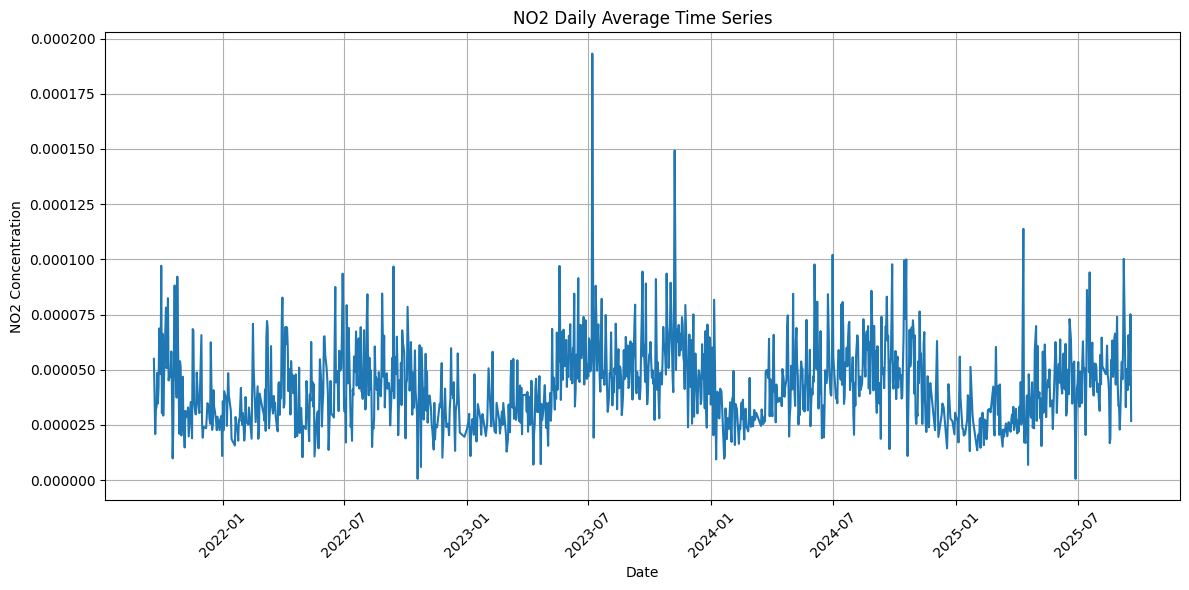

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(no2_harian_filled['t'], no2_harian_filled['NO2_mean'])
plt.title('NO2 Daily Average Time Series')
plt.xlabel('Date')
plt.ylabel('NO2 Concentration')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Mengubah menjadi data Superviesd

In [14]:
def make_supervised_lag(df_daily):
    df = df_daily.copy()

    # Pastikan tipe datetime & urut
    df['t'] = pd.to_datetime(df['t'])
    df = df.sort_values('t')

    # Normalisasi nama kolom nilai → 'NO_2'
    if 'NO2_mean' in df.columns:
        df = df.rename(columns={'NO2_mean': 'NO_2'})
    elif 'NO2' in df.columns:
        df = df.rename(columns={'NO2': 'NO_2'})
    else:
        raise ValueError("Dataframe harus memiliki kolom 'NO2' atau 'NO2_mean'.")

    # Buat kolom lag (h-1, h-2, h-3) berbasis waktu harian
    df['h-1'] = df['NO_2'].shift(1)
    df['h-2'] = df['NO_2'].shift(2)
    df['h-3'] = df['NO_2'].shift(3)

    # Ambil hanya kolom yang diminta & buang baris awal yang belum punya lag lengkap
    supervised = df[['t', 'h-3', 'h-2', 'h-1', 'NO_2']].dropna(subset=['h-3', 'h-2', 'h-1']).reset_index(drop=True)

    # (opsional) jika ingin 't' sebagai date saja, bukan datetime:
    supervised['t'] = supervised['t'].dt.date

    return supervised

# Pakai fungsi:
df = make_supervised_lag(no2_harian_filled)
print(df.head())


            t       h-3       h-2       h-1      NO_2
0  2021-09-23  0.000055  0.000038  0.000021  0.000032
1  2021-09-24  0.000038  0.000021  0.000032  0.000033
2  2021-09-25  0.000021  0.000032  0.000033  0.000049
3  2021-09-26  0.000032  0.000033  0.000049  0.000035
4  2021-09-27  0.000033  0.000049  0.000035  0.000042


Merubah data time series dengan target $NO_2$, menjadi data dengan 3 fitur tambahan.

Data fitur tambahan dihasilkan dari 3 data hari sebelumnya.

Contoh : Untuk data target tanggal 23 September 2021, menggunakan data $NO_2$ saat tanggal 22, 21, dan 20 September, dan seterusnya.

## Scalling Min-Max Normalization

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

cols_to_scale = [c for c in df.columns if c != 't']

df_scaled = df.copy()
df_scaled[cols_to_scale] = scaler.fit_transform(df_scaled[cols_to_scale])

df_scaled.head()

df = df_scaled.copy()

df.to_csv('dataset/data2.csv',index=False)

Kode tersebut membuat **MinMaxScaler(0–1)** lalu menerapkannya ke **semua kolom kecuali `t`**, sehingga setiap kolom numerik dipetakan ke rentang ([0,1]). Hasilnya disalin ke `df_scaled`, kemudian disalin kembali ke `df` dan **disimpan** sebagai CSV di `dataset/data2.csv` tanpa indeks. Singkatnya: normalisasi fitur → pratinjau (`head()`) → simpan dataset yang sudah diskalakan.


# Modeling

## Split Dataset

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

X = df[['h-3','h-2','h-1']].copy()
y = df['NO_2'].copy()
tanggal = pd.to_datetime(df['t'])

X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(X, y, tanggal, test_size=0.2, shuffle=False)


## Modeling

In [17]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

# --- scorer: MAPE dengan epsilon agar stabil saat y≈0 ---
def mape_eps(y_true, y_pred, eps=1e-3):
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100

mape_scorer = make_scorer(mape_eps, greater_is_better=False)  # minimization

# --- CV khas time series (tanpa shuffle) ---
tscv = TimeSeriesSplit(n_splits=5)

# --- ruang hyperparameter ---
param_grid = {
    "n_neighbors": [2, 3, 5, 7, 9, 11, 15, 21, 31],
    "weights": ["distance", "uniform"],
    "p": [1, 2],                       # 1=Manhattan, 2=Euclidean (masih metric='minkowski')
    "algorithm": ["auto", "ball_tree", "kd_tree"],
    "leaf_size": [15, 30, 45]
}

# --- grid search ---
knn_base = KNeighborsRegressor(metric="minkowski")
gsearch = GridSearchCV(
    estimator=knn_base,
    param_grid=param_grid,
    scoring=mape_scorer,   # pakai MAPE_eps
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

gsearch.fit(X_train, y_train)

# --- gunakan model terbaik untuk langkah berikutnya ---
knn = gsearch.best_estimator_
print("Best params:", gsearch.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best params: {'algorithm': 'auto', 'leaf_size': 15, 'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}


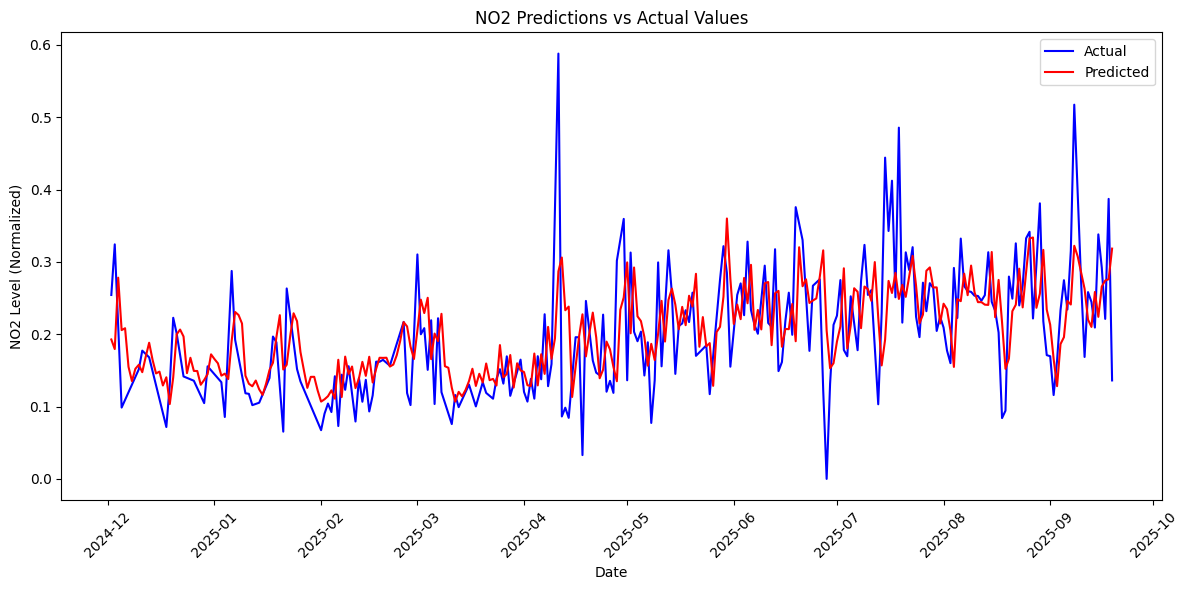

Modified MAPE: 31.77%
RMSE: 0.070803
R2 Score: 0.305806

Predicted NO2 value for next day: 2.8467585710942096
NO2 Level Category: Baik


In [18]:
def convertToMikroGramperM3(value):
    return (value * 46.006 * 10**3)

# Categorize NO2 level
def categorize_no2(value):
    if value < 50:
        return "Baik"
    elif value < 100:
        return "Sedang" 
    elif value < 200 :
        return "Tidak Sehat"
    elif value < 300:
        return "Sangat Tidak Sehat"
    else:
        return "Berbahaya"
    
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
# Calculate predictions on test set
y_pred = knn.predict(X_test)

# Calculate MAPE
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(t_test, y_test, label='Actual', color='blue')
plt.plot(t_test, y_pred, label='Predicted', color='red')
plt.title('NO2 Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('NO2 Level (Normalized)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate modified MAPE avoiding division by zero
def modified_mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape = modified_mape(y_test, y_pred)
print(f"Modified MAPE: {mape:.2f}%")

# Calculate other metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.6f}")
print(f"R2 Score: {r2:.6f}")
# Predict next day
last_row = X.iloc[-1:] 
next_day_pred = knn.predict(last_row)

# Denormalize prediction
next_day_denorm = next_day_pred * scaler.data_range_[-1] + scaler.data_min_[-1]
print(f"\nPredicted NO2 value for next day: {convertToMikroGramperM3(next_day_denorm[0])}")



category = categorize_no2(convertToMikroGramperM3(next_day_denorm[0]))
print(f"NO2 Level Category: {category}")

